<a href="https://colab.research.google.com/github/catlaughing/bangkit_project/blob/intan/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Environment Preparation

Loading required modules and libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, Concatenate, Dropout, BatchNormalization, Conv1D, \
                        MaxPooling1D, GlobalMaxPooling1D 
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import add
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
#  ! pip install -q kaggle
#  from google.colab import files
#  files.upload()

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

In [4]:
os.environ['KAGGLE_USERNAME'] = 'intanyutami'
os.environ['KAGGLE_KEY'] = '89ec7867b5214b4d33a4d922a8e66c21'

Downloading Flickr8k Datasets

In [5]:
!kaggle datasets download -d shadabhussain/flickr8k
!unzip -q flickr8k.zip -d .

 99% 2.12G/2.13G [00:36<00:00, 70.3MB/s]
100% 2.13G/2.13G [00:36<00:00, 61.9MB/s]


Downloading extracted image features

In [6]:
!kaggle datasets download -d intandea/flickr8k-image-extraction
!unzip -q flickr8k-image-extraction.zip -d .

 76% 44.0M/57.6M [00:00<00:00, 36.1MB/s]
100% 57.6M/57.6M [00:00<00:00, 62.5MB/s]


Downloading GloVe Word Embedding

In [7]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip -q glove-global-vectors-for-word-representation.zip -d .

 99% 455M/458M [00:08<00:00, 66.8MB/s]
100% 458M/458M [00:08<00:00, 56.6MB/s]


# Data Preparation

Captions Handling

In [8]:
#Get All Captions
fn = "Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
f = open(fn, 'r')
capts = f.read()

#Group all captions by filename, for references
captions = dict()
i = 0
try:
    for line in capts.split("\n"):
        txt = line.split('\t')
        fn = txt[0].split('#')[0]
        if fn not in captions.keys():
            captions[fn] = [txt[1]]
        else:
            captions[fn].append(txt[1])
        i += 1
except:
    pass

In [9]:
#Removing dots and appending startseq & endseq to all captions
def getCaptions(path):
    
    f = open(path, 'r')
    capts = f.read()
    desc = dict()

    try:
        for line in capts.split("\n"):
            image_id = line
            image_descs = captions[image_id]

            for des in image_descs:
                ws = des.split(" ")
                w = [word for word in ws if word.isalpha()]
                des = "startseq " + " ".join(w) + " endseq"
                if image_id not in desc:
                    desc[image_id] = list()
                desc[image_id].append(des)
    except:
        pass
    
    return desc

In [10]:
#Split captions to train set and validation set
train_caps = getCaptions("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
val_caps = getCaptions("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt")

Tokenize all captions and create word-index & index-word from it

In [13]:
train_captions = []
for key, desc_list in train_caps.items():
    for i in range(len(desc_list)):
        train_captions.append(desc_list[i])

tokenizer = Tokenizer(num_words=5000,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

pickle.dump(word_index,open("word_index.pkl","wb"))
pickle.dump(index_word,open("index_word.pkl","wb"))

Load the extracted image features

In [14]:
#Read Img Features
infile = open("img_extract.pkl",'rb')
img_fea = pickle.load(infile)
infile.close()

In [15]:
#Split image feature extraction to train, validation and test set
train_fns = list(train_caps.keys())
train_set = dict((k, img_fea[k]) for k in train_fns)

val_fns = list(val_caps.keys())
val_set = dict((k, img_fea[k]) for k in val_fns)

In [16]:
fn_test = "Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"
f = open(fn_test, 'r')
t = f.read()

test_fns= t.split("\n")
test_set = dict((k, img_fea[k]) for k in list(test_fns[:-1]))

# Model

<h3> Load GloVe Word-Embedding

In [17]:
embeddings_index = {} # empty dictionary
f = open("glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Map words to embedding vector

In [18]:
# Get 200-dim dense vector for each words in vocabulary
vocab_size = len(word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

<h3> Defining data generator
<p> To be used when training the model to solve memory issue

In [19]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

Model Archicture to Predict Caption

In [20]:
max_length = 34 

#Image Part
image_model = Sequential()
image_model.add(Dense(embedding_dim, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_length))

#Caption Part
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_dim)))

#Concatenate image and caption part to predict the next word
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model= Model(inputs=[image_model.input, language_model.input], outputs = out)

#Set GloVe vectors as weight at embedding layers in Caption part
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

epochs = 50
number_pics_per_batch = 6
steps = len(train_fns)//number_pics_per_batch
val_steps = len(val_fns)//number_pics_per_batch

Train the model

In [23]:
start_time = time.time()

for i in range(epochs):
    generator = data_generator(train_caps, train_set, word_index, max_length, number_pics_per_batch)
    val_gen = data_generator(val_caps, val_set, word_index, max_length, number_pics_per_batch)
    model.fit_generator(generator, validation_data = val_gen, validation_steps = val_steps,
                        epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_inc_glove.h5')

Epoch 1/1
1000/1000 [==============================] - 221s 221ms/step - loss: 5.0039 - accuracy: 0.1747 - val_loss: 5.0610 - val_accuracy: 0.2059
Epoch 1/1
1000/1000 [==============================] - 217s 217ms/step - loss: 4.5485 - accuracy: 0.2220 - val_loss: 4.6799 - val_accuracy: 0.2346
Epoch 1/1
1000/1000 [==============================] - 219s 219ms/step - loss: 4.2662 - accuracy: 0.2444 - val_loss: 4.5061 - val_accuracy: 0.2550
Epoch 1/1
1000/1000 [==============================] - 220s 220ms/step - loss: 4.1033 - accuracy: 0.2618 - val_loss: 4.4190 - val_accuracy: 0.2676
Epoch 1/1
1000/1000 [==============================] - 219s 219ms/step - loss: 3.9700 - accuracy: 0.2734 - val_loss: 4.3250 - val_accuracy: 0.2767
Epoch 1/1
1000/1000 [==============================] - 222s 222ms/step - loss: 3.8608 - accuracy: 0.2826 - val_loss: 4.2780 - val_accuracy: 0.2836
Epoch 1/1
1000/1000 [==============================] - 227s 227ms/step - loss: 3.7678 - accuracy: 0.2911 - val_loss: 4

# Evaluation

BLEU Evaluation for the quality of captions

In [24]:
from nltk.translate.bleu_score import sentence_bleu
def splitCaps(caps):
    s = []
    for c in caps:
        ws = c.split(" ")
        w = [word for word in ws if word.isalpha()]
        s.append(w)
    return s

In [28]:
def createCaption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    return final

In [29]:
train_bleu_score = []
for f in train_fns:
    fea = train_set[f]
    candidate = createCaption(fea.reshape((1,2048)))
    reference = splitCaps(captions[f])
    score = sentence_bleu(reference, candidate)
    train_bleu_score.append(score)
    #print(score)
print("Average train bleu score: ", np.mean(train_bleu_score))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average train bleu score:  0.5211697800709248


In [30]:
val_bleu_score = []
for f in val_fns:
    fea = val_set[f]
    candidate = createCaption(fea.reshape((1,2048)))
    reference = splitCaps(captions[f])
    score = sentence_bleu(reference, candidate)
    val_bleu_score.append(score)
    #print(score)
print("Average val bleu score: ", np.mean(val_bleu_score))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average val bleu score:  0.5013797946449483


Prediction

In [31]:
# select 15 random samples from validation set

from random import seed
from random import randint
# seed random number generator
seed(2121)
# generate some integers
photos = []
for _ in range(15):
    value = randint(0, len(val_fns))
    photos.append(value)

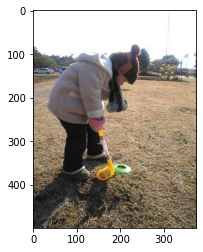

boy in a blue shirt is jumping a large blue ball


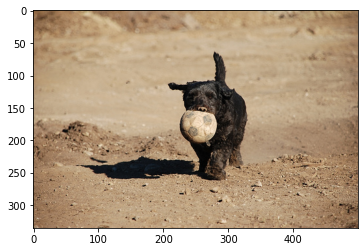

black dog is playing with a red ball


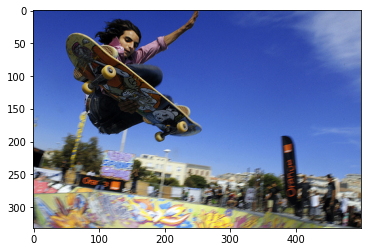

skateboarder does a trick on a ramp


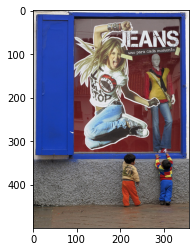

man in a red shirt is playing a guitar


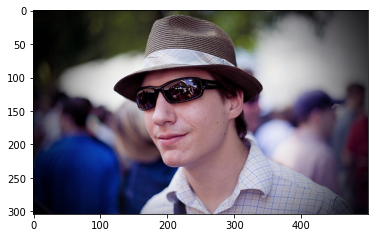

man with a red jacket and a black hat


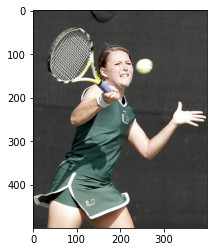

tennis player in a blue shirt and blue shorts is playing tennis


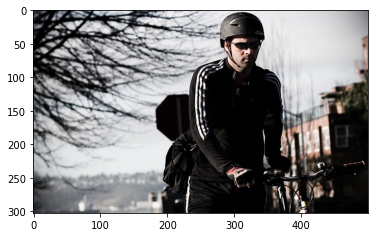

man in a red jacket and black jacket is standing


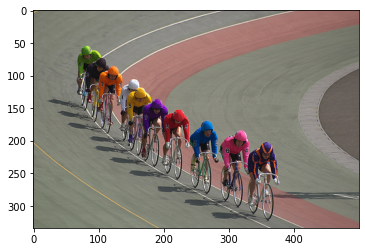

group of people are riding a red race line of other are walking down the street


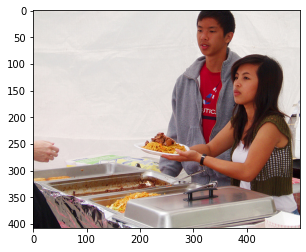

woman in a black shirt is sitting in a chair


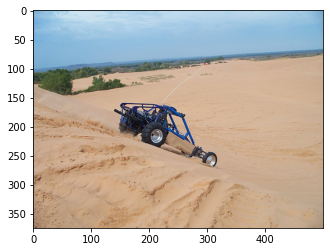

person in a yellow shirt is riding a red bike through the air


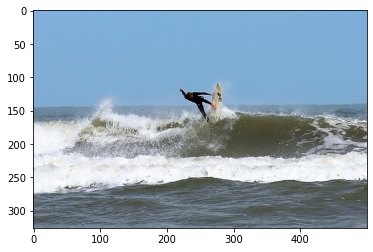

surfer is riding a wave


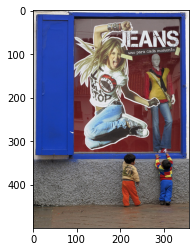

man in a red shirt is playing a guitar


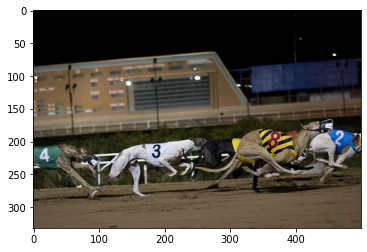

greyhounds are racing around a track


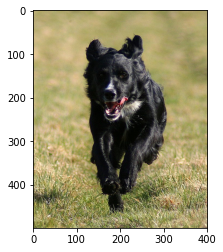

black dog is running through the grass


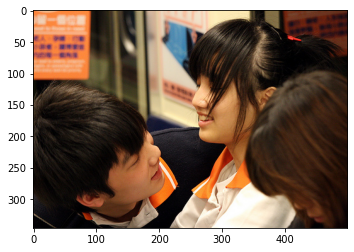

woman in a white shirt and a woman in a white shirt are posing for a picture


In [34]:
images = "Flickr_Data/Flickr_Data/Images/"
for p in photos:
    sample_test = val_fns[p]
    sample_fea = val_set[sample_test]
    x=plt.imread(images + sample_test)
    plt.imshow(x)
    plt.show()
    a = createCaption((sample_fea).reshape((1,2048)))
    print(' '.join(a))